# Dogbolt ast study

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np
from scipy import stats

## Dependencies and dataset

In [25]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics_db.csv'
REPORT_PATH = './dogbolt_bench/outputs/dogbolt_report.json'

# Reports study

In [26]:
# Load Dogbolt report
def load_dogbolt_data(path):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading file: {e}")
        return pd.DataFrame()

    rows = []
    for model_name, items in data.items():
        for item in items:
            row = {
                'judge_model': model_name,
                'binary': item.get('binary'),
                'function': item.get('function'),
                'decompiler_A': item.get('decompiler_A'),
                'decompiler_B': item.get('decompiler_B'),
                'winner': item.get('winner'),
                'winner_ast': item.get('winner_ast'),
                'motivation': item.get('motivation', ''),
                
                # Code Perplexity Metrics
                'perp_source': item.get('perplexity_source'),
                'perp_A': item.get('perplexity_A'),
                'perp_B': item.get('perplexity_B'),
                
                # AST Perplexity Metrics
                'perp_ast_source': item.get('perplexity_ast_source'),
                'perp_ast_A': item.get('perplexity_ast_A'),
                'perp_ast_B': item.get('perplexity_ast_B'),
            }
            
            # Skip records with invalid perplexity (-1)
            if (row['perp_source'] == -1 or row['perp_A'] == -1 or row['perp_B'] == -1 or
                row['perp_ast_source'] == -1 or row['perp_ast_A'] == -1 or row['perp_ast_B'] == -1):
                continue


            # Calculate Deltas (Differences)
            # Negative delta means A is better (lower perplexity) than B
            if row['perp_A'] is not None and row['perp_B'] is not None:
                row['delta_perp'] = row['perp_A'] - row['perp_B']
            else:
                row['delta_perp'] = None
                
            if row['perp_ast_A'] is not None and row['perp_ast_B'] is not None:
                row['delta_perp_ast'] = row['perp_ast_A'] - row['perp_ast_B']
            else:
                row['delta_perp_ast'] = None

            rows.append(row)

    df = pd.DataFrame(rows)
    
    num_cols = ['perp_source', 'perp_A', 'perp_B', 
                'perp_ast_source', 'perp_ast_A', 'perp_ast_B', 
                'delta_perp', 'delta_perp_ast']
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    return df

# Load data
df_db = load_dogbolt_data(REPORT_PATH)
print(f"Loaded {len(df_db)} records.")
df_db.head()

Loaded 120 records.


,judge_model,binary,function,decompiler_A,decompiler_B,winner,winner_ast,motivation,perp_source,perp_A,perp_B,perp_ast_source,perp_ast_A,perp_ast_B,delta_perp,delta_perp_ast
0,qwen-3,task-file_file_vprintf-O2,file_vprintf,binary-ninja,ghidra,B,B,Candidate B avoids `goto` statements and deep ...,3.828125,3.328125,2.921875,4.43750,4.06250,3.593750,0.406250,0.468750
1,qwen-3,task-file_file_vprintf-O2,file_vprintf,binary-ninja,hex-rays,B,B,Candidate B avoids `goto` statements and deep ...,3.828125,3.328125,2.453125,4.43750,4.06250,3.593750,0.875000,0.468750
2,qwen-3,task-file_file_vprintf-O2,file_vprintf,ghidra,hex-rays,B,A,Candidate B demonstrates cleaner scoping and s...,3.828125,2.921875,2.453125,4.43750,3.59375,3.593750,0.468750,0.000000
3,qwen-3,task-file_file_is_json-O2,file_is_json,binary-ninja,ghidra,B,TIE,Candidate B uses more structured variable name...,4.093750,3.750000,2.828125,5.65625,4.43750,3.546875,0.921875,0.890625
4,qwen-3,task-file_file_is_json-O2,file_is_json,binary-ninja,hex-rays,B,TIE,Candidate B uses more idiomatic expressions an...,4.093750,3.750000,2.468750,5.65625,4.43750,3.656250,1.281250,0.781250


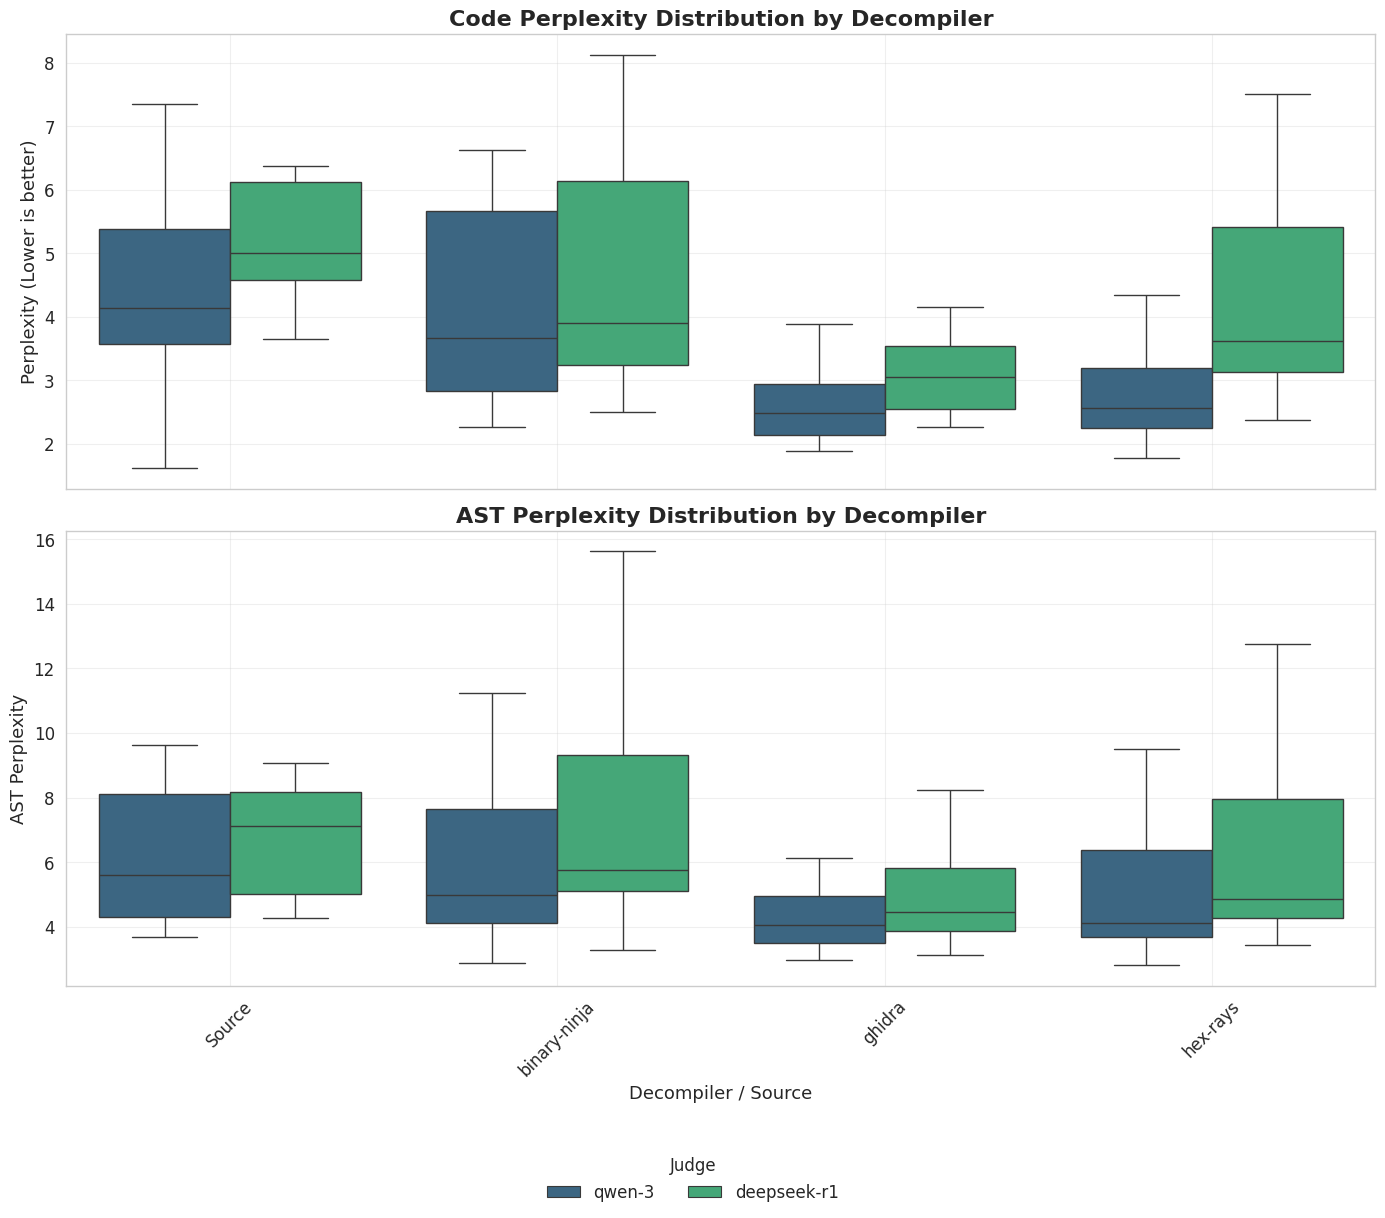

In [39]:
if not df_db.empty:
    plot_data = []

    for _, row in df_db.iterrows():
        judge = row['judge_model']

        plot_data.append({
            'Judge': judge,
            'Decompiler': 'Source',
            'Perplexity': row['perp_source'],
            'AST Perplexity': row['perp_ast_source'],
            'Type': 'Source'
        })

        if row['decompiler_A']:
            plot_data.append({
                'Judge': judge,
                'Decompiler': row['decompiler_A'],
                'Perplexity': row['perp_A'],
                'AST Perplexity': row['perp_ast_A'],
                'Type': 'Decompiler'
            })

        if row['decompiler_B']:
            plot_data.append({
                'Judge': judge,
                'Decompiler': row['decompiler_B'],
                'Perplexity': row['perp_B'],
                'AST Perplexity': row['perp_ast_B'],
                'Type': 'Decompiler'
            })

    df_plot = pd.DataFrame(plot_data)
    df_plot = df_plot.dropna(subset=['Perplexity'])
    df_plot = df_plot[df_plot['Perplexity'] != -1]

    decompilers = sorted(list(set(df_plot['Decompiler']) - {'Source'}))
    order = ['Source'] + decompilers

    df_plot_ast = df_plot.dropna(subset=['AST Perplexity'])
    df_plot_ast = df_plot_ast[df_plot_ast['AST Perplexity'] != -1]

    title_fs = 16
    axis_label_fs = 13
    tick_fs = 12
    legend_fs = 12

    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    sns.boxplot(
        data=df_plot,
        x='Decompiler',
        y='Perplexity',
        hue='Judge',
        order=order,
        showfliers=False,
        ax=axes[0],
        palette='viridis'
    )
    axes[0].set_title('Code Perplexity Distribution by Decompiler', fontsize=title_fs, fontweight='bold')
    axes[0].set_ylabel('Perplexity (Lower is better)', fontsize=axis_label_fs)
    axes[0].set_xlabel('')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='both', labelsize=tick_fs)

    if not df_plot_ast.empty:
        sns.boxplot(
            data=df_plot_ast,
            x='Decompiler',
            y='AST Perplexity',
            hue='Judge',
            order=order,
            showfliers=False,
            ax=axes[1],
            palette='viridis'
        )
        axes[1].set_title('AST Perplexity Distribution by Decompiler', fontsize=title_fs, fontweight='bold')
        axes[1].set_ylabel('AST Perplexity', fontsize=axis_label_fs)
        axes[1].set_xlabel('Decompiler / Source', fontsize=axis_label_fs)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='both', labelsize=tick_fs)
    else:
        axes[1].set_visible(False)

    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    # Global legend like your reference plot
    handles, labels = axes[0].get_legend_handles_labels()
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()
    if len(axes) > 1 and axes[1].get_legend() is not None:
        axes[1].get_legend().remove()

    if handles and labels:
        fig.legend(
            handles, labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.02),
            ncol=max(1, len(labels)),
            title='Judge',
            fontsize=legend_fs,
            title_fontsize=legend_fs,
            frameon=False
        )

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()

In [28]:

def load_data(path):
    with open(path, 'r') as f:
        data = json.load(f)

    rows = []
    for model_name, items in data.items():
        for item in items:
            row = {
                'judge_model': model_name,
                'binary': item.get('binary'),
                'decompiler_A': item.get('decompiler_A'),
                'decompiler_B': item.get('decompiler_B'),
                
                'winner_s': item.get('winner_s'),     
                'winner': item.get('winner'),          
                'winner_ast': item.get('winner_ast'),      
                'winner_ast_s': item.get('winner_ast_s'), 
                
                'perplexity_A': item.get('perplexity_A'),
                'perplexity_B': item.get('perplexity_B'),
                'perplexity_ast_A': item.get('perplexity_ast_A'),
                'perplexity_ast_B': item.get('perplexity_ast_B'),

                'decompiler_A_code': item.get('code_A'),
                'decompiler_B_code': item.get('code_B'),
                'ast_A': item.get('ast_A'),
                'ast_B': item.get('ast_B'),
            }
            rows.append(row)

    return pd.DataFrame(rows)

df = load_data(REPORT_PATH)

## Distribution victory trough decompilers

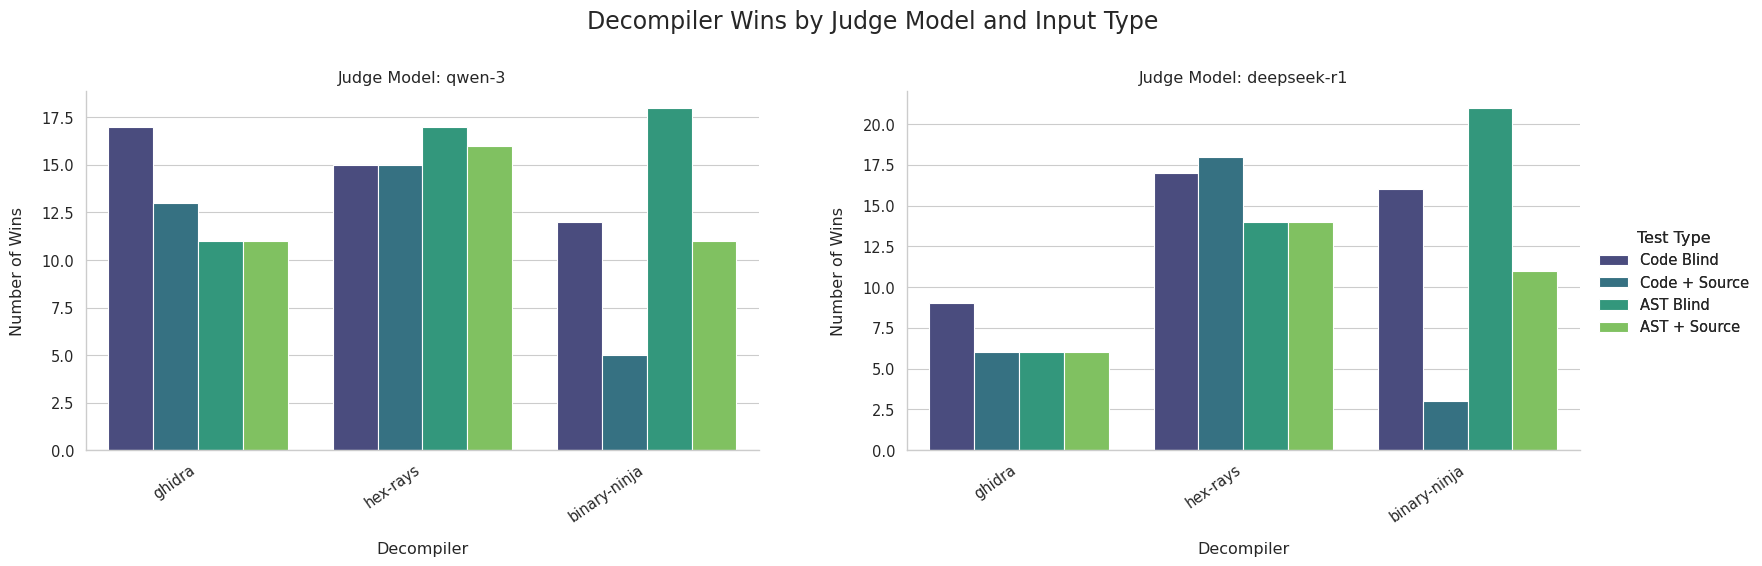


--- Detailed analysis (wins by Judge and Decompiler) ---
Decompiler                 Tie  binary-ninja  ghidra  hex-rays
Judge       Test Type                                         
deepseek-r1 AST + Source    25            11       6        14
            AST Blind       19            21       6        14
            Code + Source   30             3       6        18
            Code Blind      18            16       9        17
qwen-3      AST + Source    17            11      11        16
            AST Blind       14            18      11        17
            Code + Source   23             5      13        15
            Code Blind      16            12      17        15


In [55]:
def prepare_faceted_data(df_all):
    victory_map = {
        'winner': 'Code Blind',
        'winner_s': 'Code + Source',
        'winner_ast': 'AST Blind',
        'winner_ast_s': 'AST + Source'
    }

    rows = []
    for col, label in victory_map.items():
        if col in df_all.columns:
            for _, row in df_all.iterrows():
                w = str(row[col]).strip().upper()
                winner_name = None

                if w == 'A':
                    winner_name = row['decompiler_A']
                elif w == 'B':
                    winner_name = row['decompiler_B']
                elif w == 'TIE':
                    winner_name = 'Tie'

                if winner_name:
                    rows.append({
                        'Judge': row['judge_model'],
                        'Decompiler': winner_name,
                        'Test Type': label
                    })

    return pd.DataFrame(rows)


df_faceted = prepare_faceted_data(df)

g = sns.catplot(
    data=df_faceted[df_faceted['Decompiler'] != 'Tie'],
    x='Decompiler',
    hue='Test Type',
    col='Judge',
    kind='count',
    palette='viridis',
    height=5.8,
    aspect=1.25,
    col_wrap=2,
    sharey=False,

)

g.set_axis_labels("Decompiler", "Number of Wins")
g.set_titles("Judge Model: {col_name}")
g.add_legend(title="Test Type")

# sns.move_legend(
#     g,
#     "lower center",
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=2,
#     frameon=False
# )

for ax in g.axes.flat:
    ax.set_xlabel("Decompiler", labelpad=12)
    ax.set_ylabel("Number of Wins", labelpad=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
        tick.set_ha('right')

g.figure.subplots_adjust(top=0.84, bottom=0.22, hspace=0.40, wspace=0.22)
g.figure.suptitle("Decompiler Wins by Judge Model and Input Type", fontsize=17)

plt.show()

print("\n--- Detailed analysis (wins by Judge and Decompiler) ---")
summary = df_faceted.groupby(['Judge', 'Test Type', 'Decompiler']).size().unstack(fill_value=0)
print(summary)

## Coherence

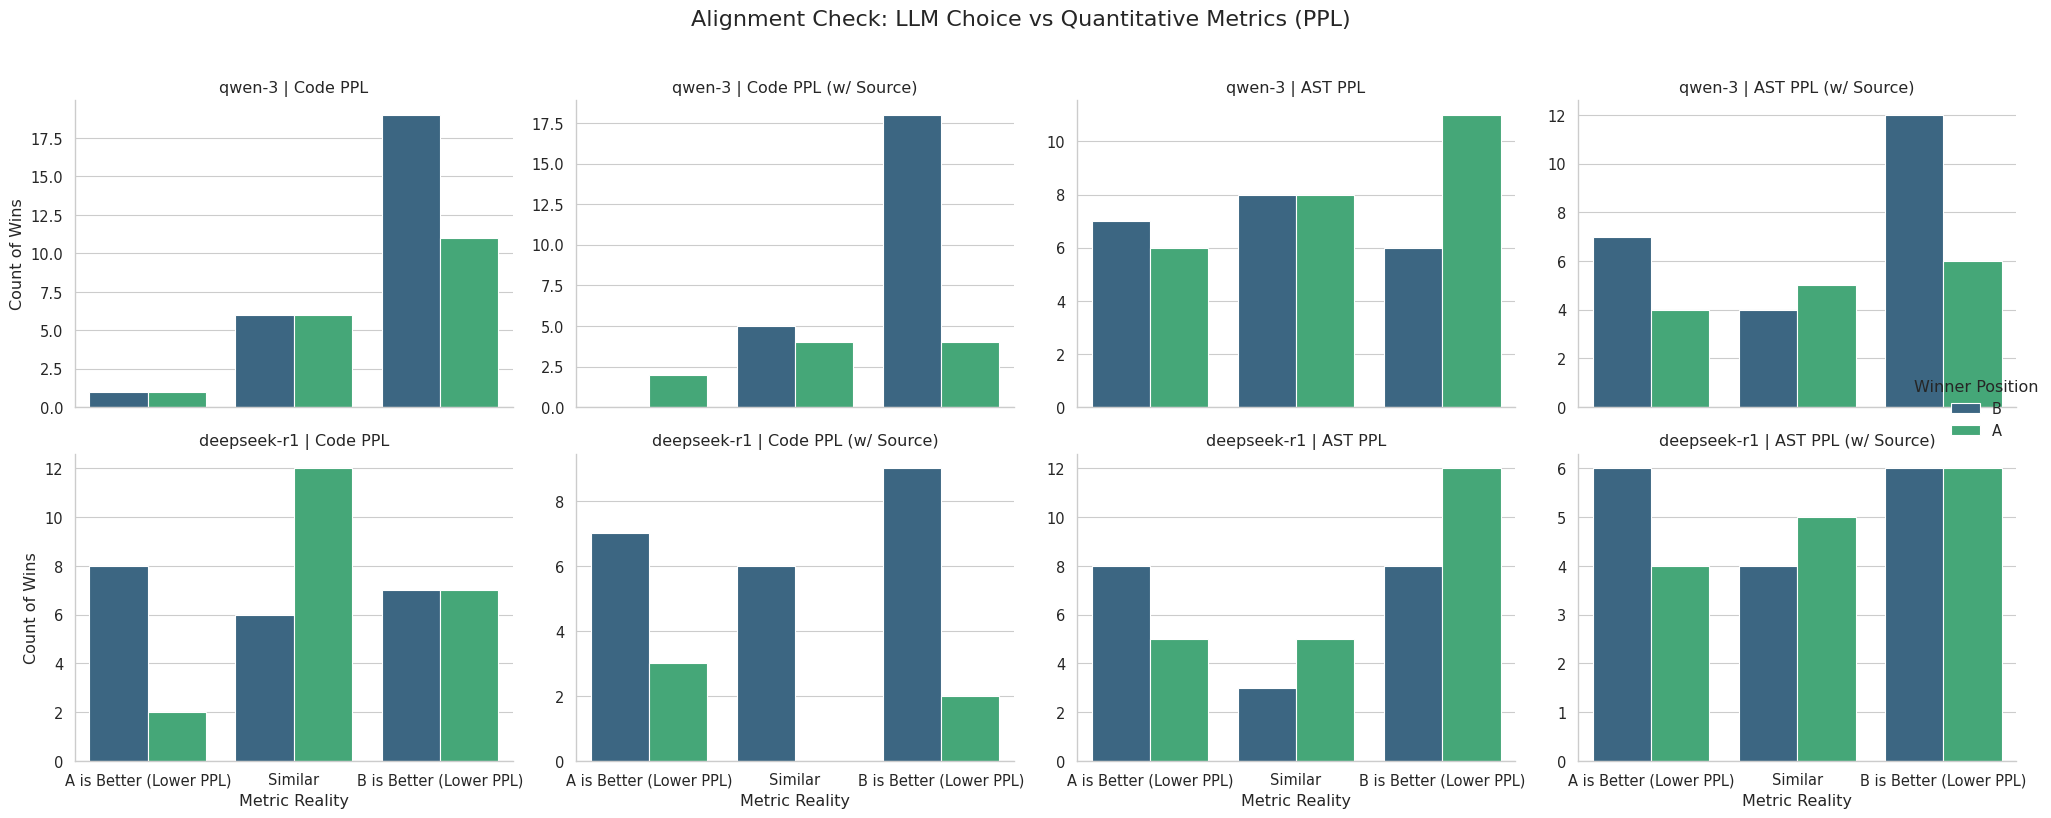

In [46]:
LAMBDA = 0.5 

alignment_data = []

mapping = {
    'winner': ('Code PPL', 'perplexity_A', 'perplexity_B'),
    'winner_s': ('Code PPL (w/ Source)', 'perplexity_A', 'perplexity_B'),
    'winner_ast': ('AST PPL', 'perplexity_ast_A', 'perplexity_ast_B'),
    'winner_ast_s': ('AST PPL (w/ Source)', 'perplexity_ast_A', 'perplexity_ast_B')
}

for col, (label, met_a, met_b) in mapping.items():
    temp = df.dropna(subset=[col, met_a, met_b]).copy()
    temp = temp[temp[col].isin(['A', 'B'])]
    
    for _, row in temp.iterrows():
        delta = row[met_a] - row[met_b]
        
        if delta < -LAMBDA:
            reality = 'A is Better (Lower PPL)'
        elif delta > LAMBDA:
            reality = 'B is Better (Lower PPL)'
        else:
            reality = 'Similar'
            
        alignment_data.append({
            'Judge': row['judge_model'],
            'Test Type': label,
            'Winner Position': row[col],
            'Reality': reality,
            'Comparison': f"{row['decompiler_A']} vs {row['decompiler_B']}"
        })

df_align = pd.DataFrame(alignment_data)

g = sns.catplot(
    data=df_align,
    x='Reality',
    hue='Winner Position',
    col='Test Type',
    row='Judge',
    kind='count',
    palette='viridis',
    order=['A is Better (Lower PPL)', 'Similar', 'B is Better (Lower PPL)'],
    height=4, aspect=1.2,
    sharey=False
)

g.figure.suptitle('Alignment Check: LLM Choice vs Quantitative Metrics (PPL)', y=1.02, fontsize=16)
g.set_titles("{row_name} | {col_name}")
g.set_axis_labels("Metric Reality", "Count of Wins")



plt.tight_layout()
plt.show()

## Length Bias

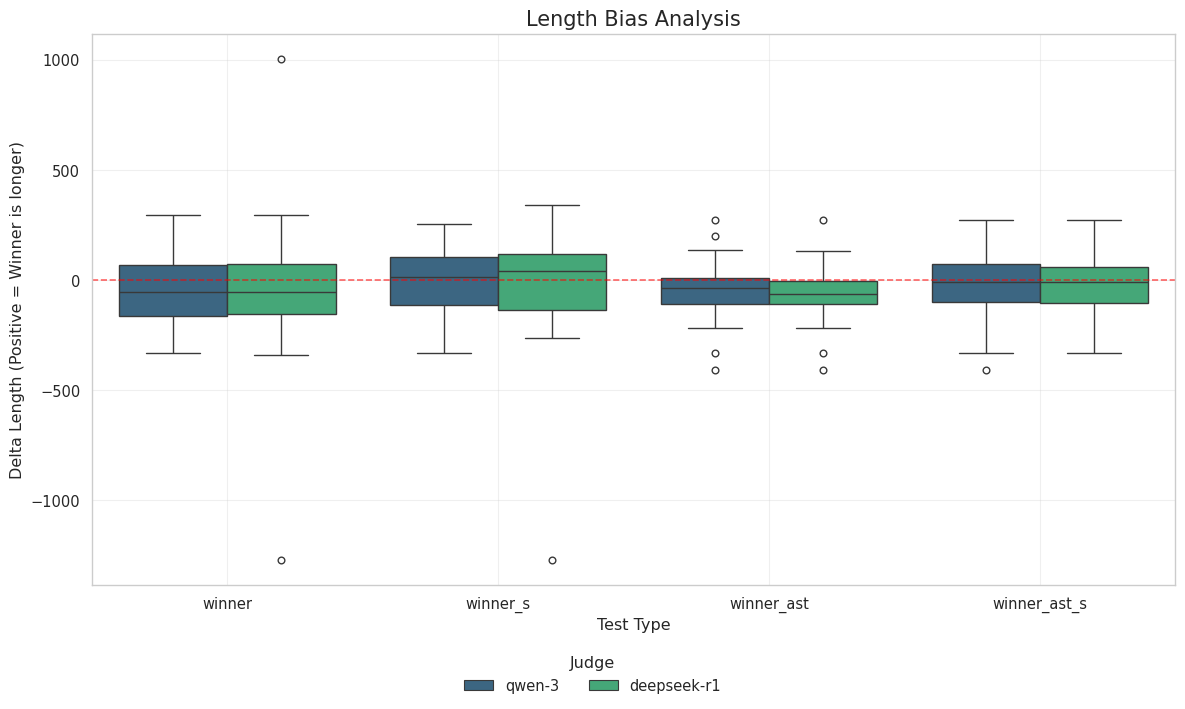

In [41]:
bias_data = []

test_cols = {
    'winner': ('len_A', 'len_B'),
    'winner_s': ('len_A', 'len_B'),
    'winner_ast': ('len_ast_A', 'len_ast_B'),
    'winner_ast_s': ('len_ast_A', 'len_ast_B')
}

df['len_A'] = df['decompiler_A_code'].str.len()
df['len_B'] = df['decompiler_B_code'].str.len()
df['len_ast_A'] = df['ast_A'].astype(str).str.len()
df['len_ast_B'] = df['ast_B'].astype(str).str.len()

for col, (l_a, l_b) in test_cols.items():
    temp = df[df[col].isin(['A', 'B'])].copy()

    for _, row in temp.iterrows():
        if row[col] == 'A':
            delta = row[l_a] - row[l_b]
        else:
            delta = row[l_b] - row[l_a]

        bias_data.append({
            'Judge': row['judge_model'],
            'Test Type': col,
            'Delta Length (Winner - Loser)': delta
        })

df_bias = pd.DataFrame(bias_data)

fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(
    data=df_bias,
    x='Test Type',
    y='Delta Length (Winner - Loser)',
    hue='Judge',
    palette='viridis',
    ax=ax
)

ax.axhline(0, color='red', linestyle='--', alpha=0.6)
ax.set_title('Length Bias Analysis', fontsize=15)
ax.set_ylabel('Delta Length (Positive = Winner is longer)')
ax.grid(True, alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
if ax.get_legend() is not None:
    ax.get_legend().remove()

fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=max(1, len(labels)),
    title='Judge',
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

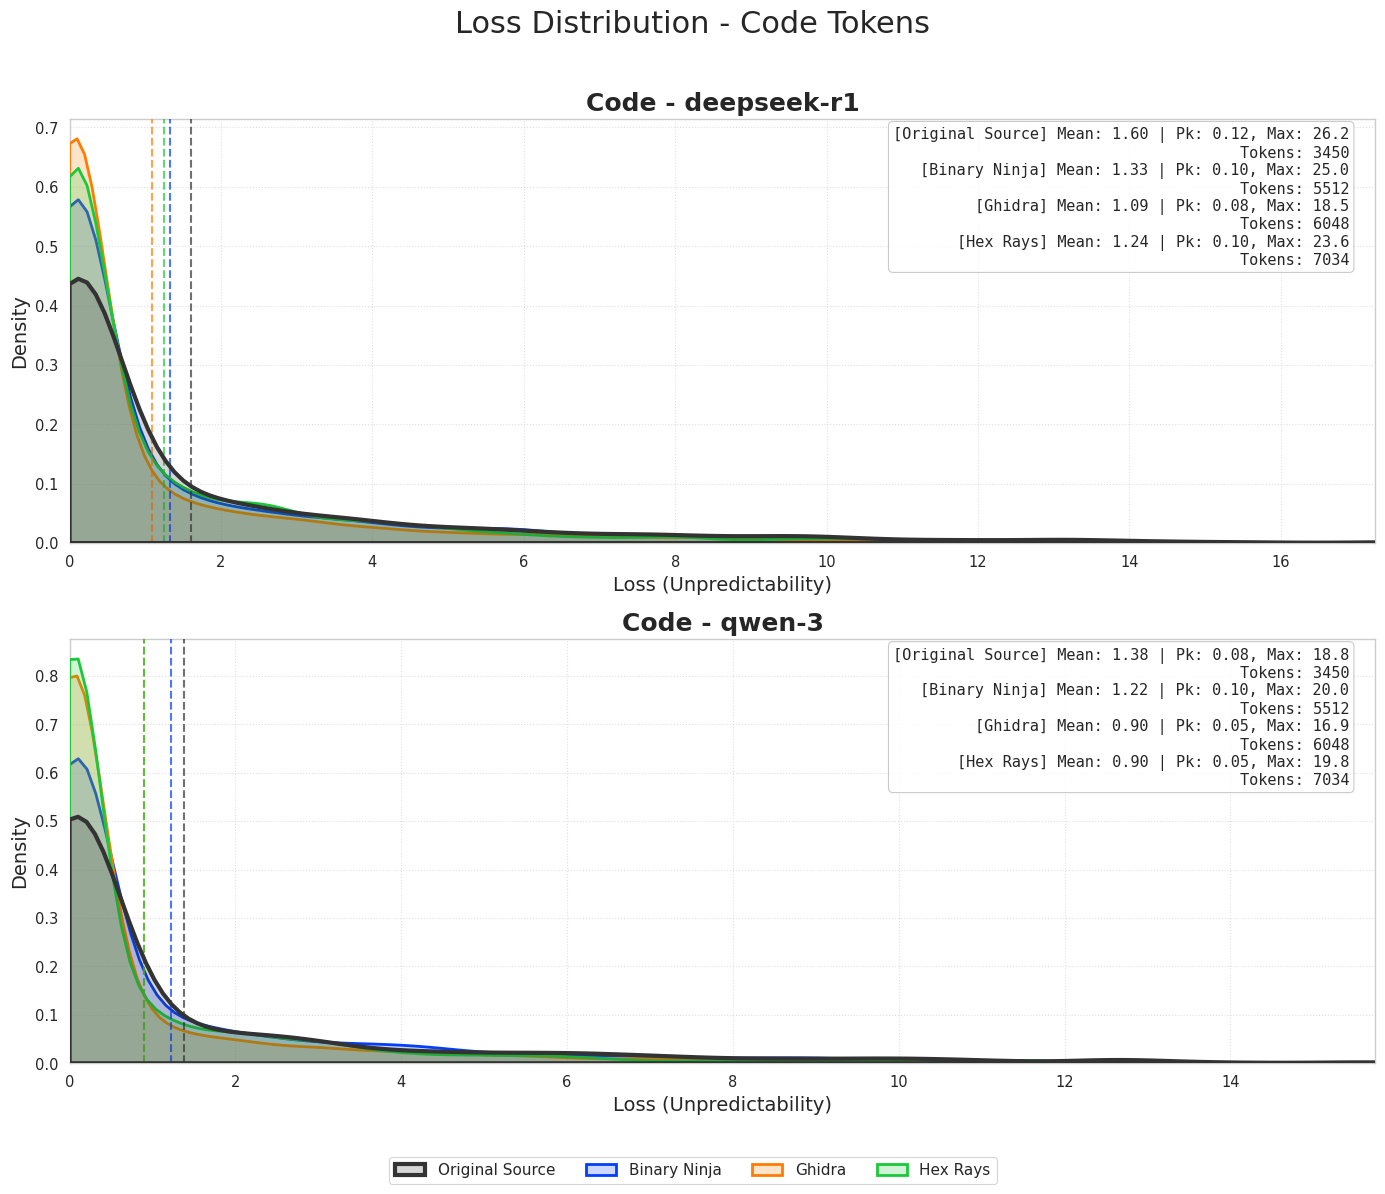

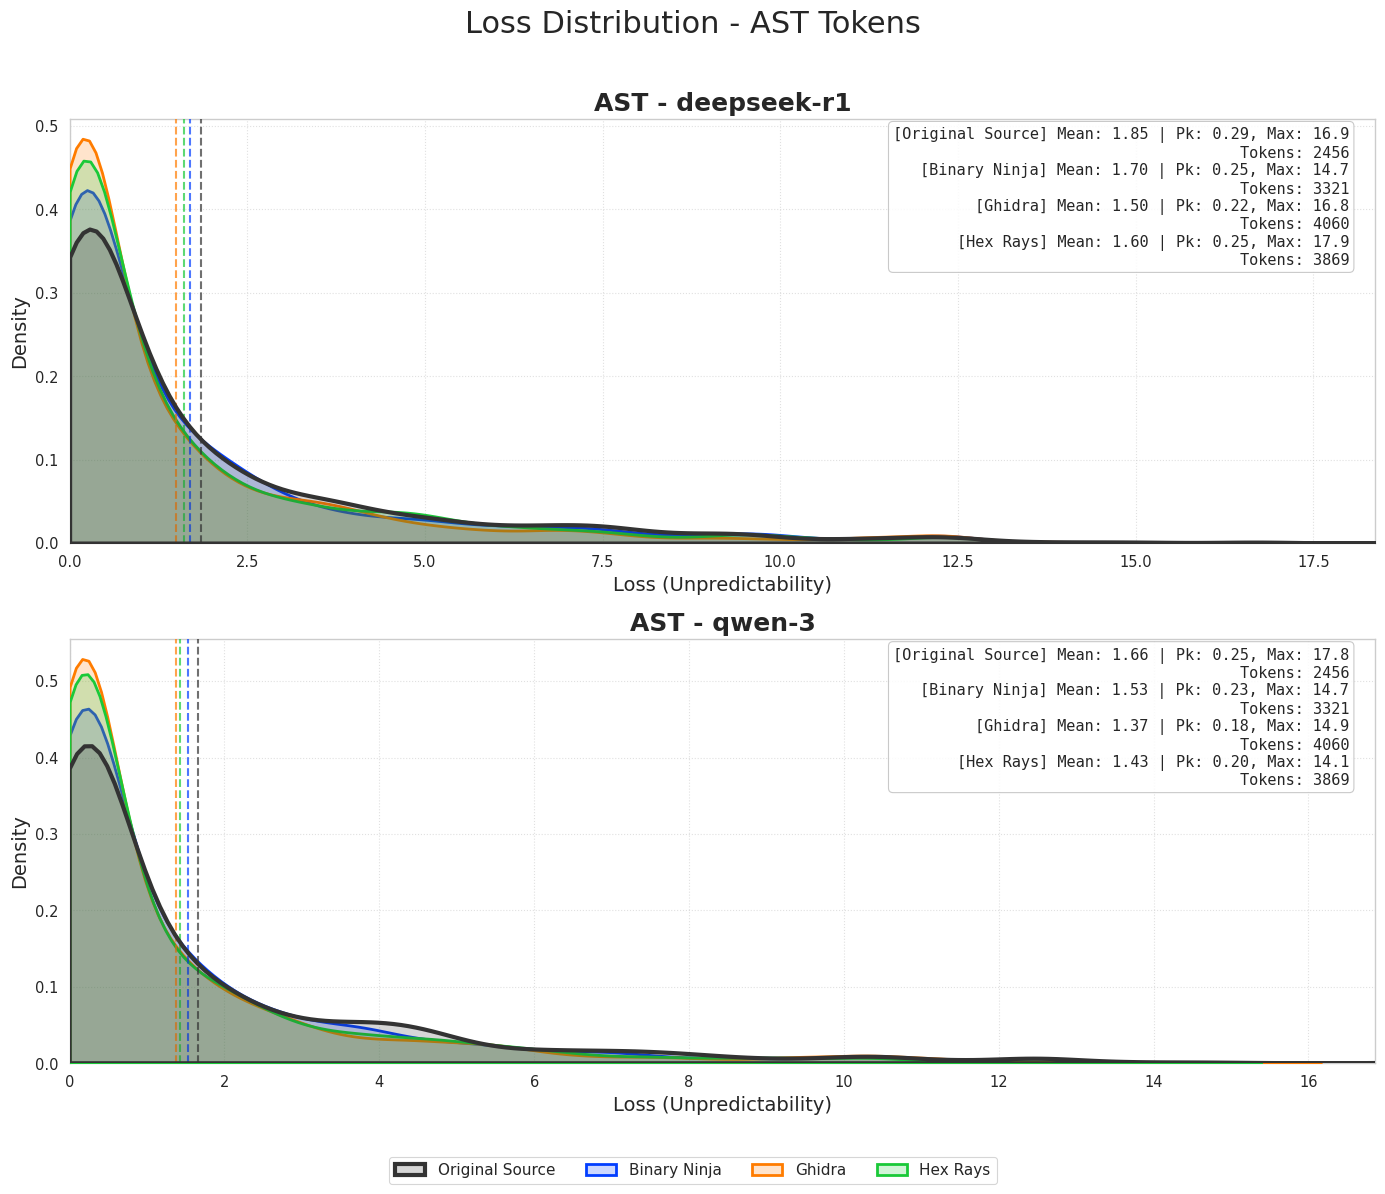

In [40]:
def plot_loss_distributions_split(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    models = sorted(data.keys())
    n_models = len(models)

    def get_kde_stats(data_list):
        if not data_list or len(data_list) < 2:
            return 0, 0, 0
        mean_val = np.mean(data_list)
        max_val = np.max(data_list)
        try:
            kde = stats.gaussian_kde(data_list)
            x_grid = np.linspace(0, np.percentile(data_list, 99.5), 500)
            y_grid = kde(x_grid)
            peak_loc = x_grid[np.argmax(y_grid)]
        except Exception:
            peak_loc = 0
        return mean_val, peak_loc, max_val

    palette = sns.color_palette("bright", n_colors=10)
    decompiler_colors = {}

    def draw_figure(is_ast=False):
        row_name = "AST" if is_ast else "Code"
        fig, axes = plt.subplots(n_models, 1, figsize=(14, 6 * n_models), squeeze=False)

        legend_map = {}  # label -> handle

        for i, model_id in enumerate(models):
            ax = axes[i, 0]
            collected = {}

            for _, task_data in data[model_id].items():
                for key, val in task_data.items():
                    if is_ast:
                        if key.endswith("_ast_loss"):
                            category = key.replace("_ast_loss", "")
                            collected.setdefault(category, []).extend(val.get("losses", []))
                    else:
                        if key.endswith("_loss") and "_ast" not in key:
                            category = key.replace("_loss", "")
                            collected.setdefault(category, []).extend(val.get("losses", []))

            cats = sorted(collected.keys())
            if "source" in cats:
                cats.remove("source")
                cats = ["source"] + cats

            all_model_losses = [l for c in collected.values() for l in c]
            if not all_model_losses:
                ax.set_title(f"{row_name} - {model_id} (no data)", fontsize=16, fontweight="bold")
                ax.axis("off")
                continue

            cutoff_x = np.percentile(all_model_losses, 99)
            stats_lines = []

            for cat in cats:
                losses = collected[cat]
                if not losses:
                    continue

                if cat == "source":
                    color, label, linewidth, zorder = "#333333", "Original Source", 3, 10
                else:
                    if cat not in decompiler_colors:
                        decompiler_colors[cat] = palette[len(decompiler_colors) % 10]
                    color = decompiler_colors[cat]
                    label = cat.replace("-", " ").title()
                    linewidth, zorder = 2, 5

                sns.kdeplot(
                    losses,
                    fill=True,
                    color=color,
                    label=label,
                    clip=(0, cutoff_x * 2),
                    ax=ax,
                    linewidth=linewidth,
                    alpha=0.2,
                    zorder=zorder
                )

                # capture one handle per label for figure legend
                if label not in legend_map:
                    h, l = ax.get_legend_handles_labels()
                    if l:
                        legend_map.update(dict(zip(l, h)))

                m, pl, max_v = get_kde_stats(losses)
                ax.axvline(m, color=color, linestyle="--", alpha=0.7, linewidth=1.5, zorder=zorder + 1)
                stats_lines.append(f"[{label}] Mean: {m:.2f} | Pk: {pl:.2f}, Max: {max_v:.1f}")
                stats_lines.append(f"Tokens: {len(losses)}")

            ax.set_title(f"{row_name} - {model_id}", fontsize=18, fontweight="bold")
            ax.set_xlabel("Loss (Unpredictability)", fontsize=14)
            ax.set_ylabel("Density", fontsize=14)
            ax.set_xlim(0, cutoff_x * 1.5)
            ax.grid(True, linestyle=":", alpha=0.6)

            props = dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="silver")
            ax.text(
                0.98, 0.98, "\n".join(stats_lines),
                transform=ax.transAxes, fontsize=11,
                verticalalignment="top", horizontalalignment="right",
                bbox=props, fontfamily="monospace"
            )

            # remove axis legend
            if ax.get_legend() is not None:
                ax.get_legend().remove()

        # figure-level legend under the plots
        if legend_map:
            fig.legend(
                legend_map.values(),
                legend_map.keys(),
                loc="lower center",
                bbox_to_anchor=(0.5, 0.01),
                ncol=min(4, len(legend_map)),
                fontsize=11,
                frameon=True
            )

        fig.suptitle(f"Loss Distribution - {row_name} Tokens", fontsize=22, y=0.995)
        fig.tight_layout(rect=[0, 0.06, 1, 0.98])  # leave room for bottom legend
        plt.show()

    draw_figure(is_ast=False)
    draw_figure(is_ast=True)


plot_loss_distributions_split('./dogbolt_bench/outputs/dogbolt_report_loss.json')

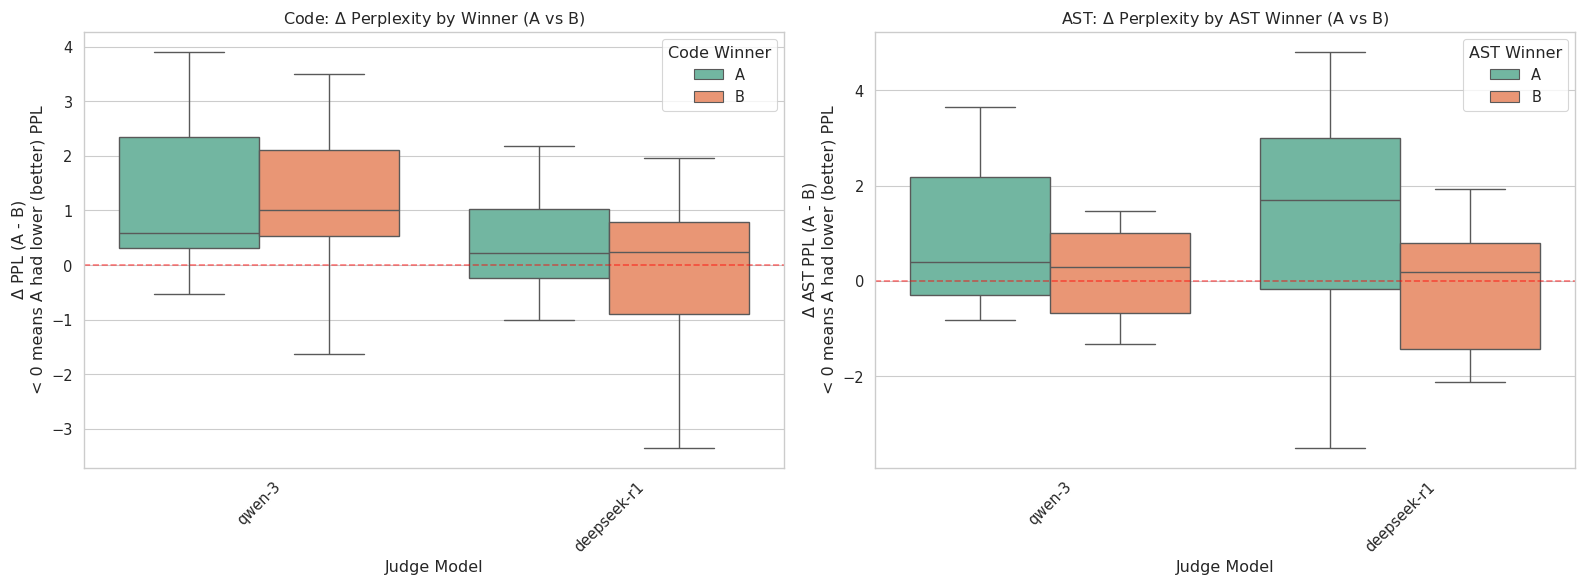


--- Dogbolt Correlation Results (Point-Biserial) ---
Note: A negative 'r' indicates that when A wins (Winner=1),
the Delta PPL is negative (meaning Decompiler A had LOWER/BETTER perplexity).


,Model,Code Corr (r),Code p-value,Code N,AST Corr (r),AST p-value,AST N
0,qwen-3,0.1953,0.204,44,0.2292,0.1255,46
1,deepseek-r1,0.0352,0.825,42,0.2283,0.1511,41


         Model  Code Corr (r)  Code p-value  Code N  AST Corr (r)  \
0       qwen-3         0.1953         0.204      44        0.2292   
1  deepseek-r1         0.0352         0.825      42        0.2283   

   AST p-value  AST N  
0       0.1255     46  
1       0.1511     41  


In [33]:
def evaluate_dogbolt_correlations(df):
    df_corr = df.copy()
        
    # Standardize string formatting for winners
    df_corr['code_winner_clean'] = df_corr['winner'].astype(str).str.strip().str.upper()
    df_corr['ast_winner_clean'] = df_corr['winner_ast'].astype(str).str.strip().str.upper()
    
    def binarize_winner(winner):
        if winner == 'A': return 1
        elif winner == 'B': return 0
        return np.nan
    
    df_corr['code_winner_bin'] = df_corr['code_winner_clean'].apply(binarize_winner)
    df_corr['ast_winner_bin'] = df_corr['ast_winner_clean'].apply(binarize_winner)
    
    df_code = df_corr.dropna(subset=['delta_perp', 'code_winner_bin']).copy()
    df_ast = df_corr.dropna(subset=['delta_perp_ast', 'ast_winner_bin']).copy()
    
    results = []
    
    for model in df_corr['judge_model'].dropna().unique():
        model_code = df_code[df_code['judge_model'] == model]
        if len(model_code) > 2:
            r_code, p_code = stats.pointbiserialr(model_code['code_winner_bin'], model_code['delta_perp'])
        else:
            r_code, p_code = np.nan, np.nan
            
        model_ast = df_ast[df_ast['judge_model'] == model]
        if len(model_ast) > 2:
            r_ast, p_ast = stats.pointbiserialr(model_ast['ast_winner_bin'], model_ast['delta_perp_ast'])
        else:
            r_ast, p_ast = np.nan, np.nan
            
        results.append({
            'Model': model,
            'Code Corr (r)': r_code,
            'Code p-value': p_code,
            'Code N': len(model_code),
            'AST Corr (r)': r_ast,
            'AST p-value': p_ast,
            'AST N': len(model_ast)
        })
        
    df_results = pd.DataFrame(results).round(4)
    
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    if not df_code.empty:
        sns.boxplot(
            data=df_code, x='judge_model', y='delta_perp', hue='code_winner_clean', 
            ax=axes[0], palette="Set2", showfliers=False, hue_order=['A', 'B']
        )
        axes[0].set_title('Code: $\Delta$ Perplexity by Winner (A vs B)')
        axes[0].set_ylabel('$\Delta$ PPL (A - B)\n< 0 means A had lower (better) PPL')
        axes[0].set_xlabel('Judge Model')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title='Code Winner')
        axes[0].axhline(0, color='red', linestyle='--', alpha=0.5) # Zero line
    
    if not df_ast.empty:
        sns.boxplot(
            data=df_ast, x='judge_model', y='delta_perp_ast', hue='ast_winner_clean', 
            ax=axes[1], palette="Set2", showfliers=False, hue_order=['A', 'B']
        )
        axes[1].set_title('AST: $\Delta$ Perplexity by AST Winner (A vs B)')
        axes[1].set_ylabel('$\Delta$ AST PPL (A - B)\n< 0 means A had lower (better) PPL')
        axes[1].set_xlabel('Judge Model')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(title='AST Winner')
        axes[1].axhline(0, color='red', linestyle='--', alpha=0.5) # Zero line
    
    plt.tight_layout()
    plt.show()
    
    return df_results, df_code, df_ast

corr_table_db, valid_code_db, valid_ast_db = evaluate_dogbolt_correlations(df_db)

print("\n--- Dogbolt Correlation Results (Point-Biserial) ---")
print("Note: A negative 'r' indicates that when A wins (Winner=1),")
print("the Delta PPL is negative (meaning Decompiler A had LOWER/BETTER perplexity).")
display(corr_table_db)
print(corr_table_db)